In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [14]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        
        # Set memory growth limit
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

Num GPUs Available:  1
1 Physical GPUs, 1 Logical GPU
Physical devices cannot be modified after being initialized


In [15]:
img_height, img_width = 48, 48
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'train',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',  
    label_mode='categorical'  
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'test',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode='categorical'
)

Found 28709 files belonging to 7 classes.
Found 7178 files belonging to 7 classes.


In [16]:
def create_custom_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax') 
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [17]:
def create_custom_model_v2():
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(img_height, img_width, 1)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(512, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(512, (3, 3), padding='same', activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        GlobalAveragePooling2D(),
        
        Dense(2048, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(7, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [18]:
def create_custom_model_v3():
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(48, 48, 1), kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        GlobalAveragePooling2D(),
        
        Dense(2048, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(512, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(7, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [19]:

# ? Keras Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=6, 
    restore_best_weights=True, 
    verbose=1,
    min_delta=0.0001,
    mode='max'
)

model_checkpoint = ModelCheckpoint(
    'custom_model_v2.h5', 
    monitor='val_accuracy', 
    save_best_only=True, 
    verbose=1,
    save_weights_only=False,
    mode='max'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy', 
    factor=0.1, 
    patience=3, 
    min_lr=0.0001, 
    verbose=1,
    mode='max'
)

In [20]:

# ? Dictionary of models to train
models = {
    'custom_model_v1': create_custom_model(),
    'custom_model_v2': create_custom_model_v2(),
    'custom_model_v3': create_custom_model_v3()
}

# ? Create a pipeline that generates a model for each model in the models dictionary and saves the training history log to a file
def run_model_generation():
    for model_name, model in models.items():
        history = model.fit(
            train_ds,
            validation_data=test_ds,
            epochs=100,
            callbacks=[early_stopping, model_checkpoint, reduce_lr]
        )
        
        model.save(model_name + '.h5')
        
        with open(model_name + '_history.txt', 'w') as f:
            f.write(str(history.history))

# ? Uncomment the following line to run the model generation pipeline
# run_model_generation()

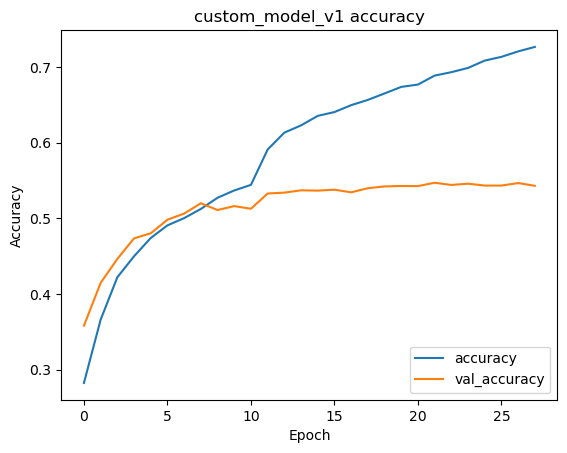

custom_model_v1 achieved the highest validation accuracy of 0.5470883250236511 at epoch 22
custom_model_v1 had a final accuracy of 0.6933366060256958 and a final validation accuracy of 0.5441626906394958


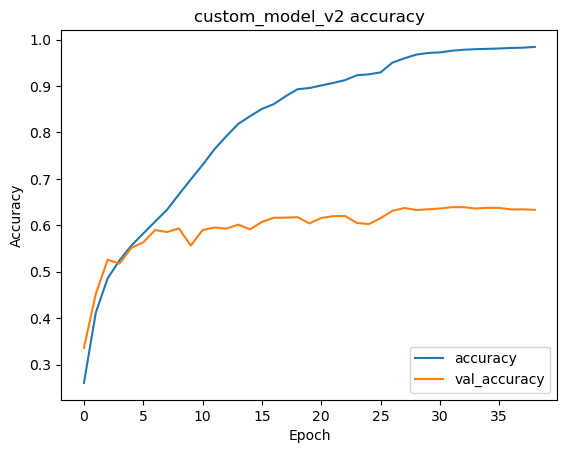

custom_model_v2 achieved the highest validation accuracy of 0.6390359401702881 at epoch 33
custom_model_v2 had a final accuracy of 0.9791703224182129 and a final validation accuracy of 0.6361103653907776


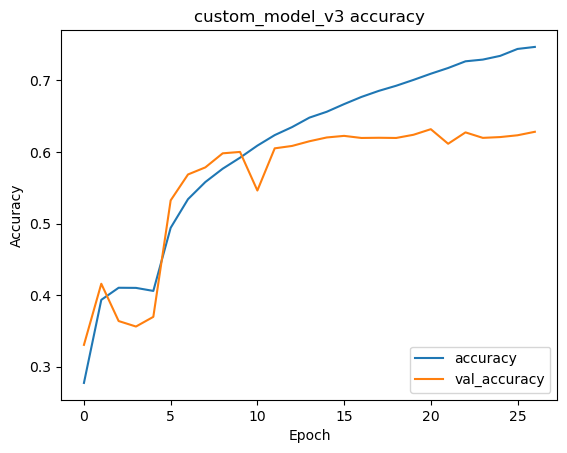

custom_model_v3 achieved the highest validation accuracy of 0.6317915916442871 at epoch 21
custom_model_v3 had a final accuracy of 0.7173011898994446 and a final validation accuracy of 0.6114516854286194


In [21]:
# Read log files and display metrics and statistics
import matplotlib.pyplot as plt

for model_name in models.keys():
    with open(model_name + '_history.txt', 'r') as f:
        history = eval(f.read())
        
        # ? Plot training and validation accuracy
        plt.figure()
        plt.plot(history['accuracy'], label='accuracy')
        plt.plot(history['val_accuracy'], label='val_accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(loc='lower right')
        plt.title(model_name + ' accuracy')
        plt.show()
        
        # ? Plot training and validation loss
        # plt.figure()
        # plt.plot(history['loss'], label='loss')
        # plt.plot(history['val_loss'], label='val_loss')
        # plt.xlabel('Epoch')
        # plt.ylabel('Loss')
        # plt.legend(loc='upper right')
        # plt.title(model_name + ' loss')
        # plt.show()
        
        # ? Display the epoch with the highest validation accuracy
        max_val_accuracy = max(history['val_accuracy'])
        max_val_accuracy_epoch = history['val_accuracy'].index(max_val_accuracy)
        print(f'{model_name} achieved the highest validation accuracy of {max_val_accuracy} at epoch {max_val_accuracy_epoch}')
        print(f'{model_name} had a final accuracy of {history["accuracy"][max_val_accuracy_epoch]} and a final validation accuracy of {history["val_accuracy"][max_val_accuracy_epoch]}')

Deep Face Comparison

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

# Use ImageDataGenerator for preprocessing
data_generator = ImageDataGenerator(rescale=1.0/255)

validation_generator = data_generator.flow_from_directory(
    'test',
    target_size=(48, 48),
    batch_size=32,
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False
)

# Get the class labels from the generator
class_indices = validation_generator.class_indices
class_labels = {v: k for k, v in class_indices.items()}

Found 7178 images belonging to 7 classes.


In [14]:
from deepface import DeepFace
import os

# Function to map DeepFace emotions to your class labels
def map_emotion(emotion):
    mapping = {
        'angry': 'angry',
        'disgust': 'disgust',
        'fear': 'fear',
        'happy': 'happy',
        'sad': 'sad',
        'surprise': 'surprise',
        'neutral': 'neutral'
    }
    return mapping.get(emotion, 'neutral')

# Store the predictions and true labels
deepface_predictions = []
true_labels = []

# Loop through the validation dataset
for i in range(len(validation_generator)):
    x_batch, y_batch = validation_generator[i]
    for j in range(len(x_batch)):
        img = x_batch[j]
        true_label = class_labels[np.argmax(y_batch[j])]
        
        # Convert the image to RGB format
        img_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(img)).numpy()
        
        # Convert the image to the correct format for DeepFace (uint8)
        img_rgb = (img_rgb * 255).astype(np.uint8)
        
        # Use DeepFace to analyze the image
        results = DeepFace.analyze(img_path=img_rgb, actions=['emotion'], enforce_detection=False)
        
        # If results is a list, iterate through the list
        if isinstance(results, list):
            for result in results:
                # Map the DeepFace emotion to your class label
                predicted_emotion = map_emotion(result['dominant_emotion'])
                deepface_predictions.append(predicted_emotion)
                true_labels.append(true_label)
        else:
            # Map the DeepFace emotion to your class label
            predicted_emotion = map_emotion(results['dominant_emotion'])
            deepface_predictions.append(predicted_emotion)
            true_labels.append(true_label)

# Convert to numpy arrays for evaluation
deepface_predictions = np.array(deepface_predictions)
true_labels = np.array(true_labels)


In [15]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(true_labels, deepface_predictions)
print(f"DeepFace Model Accuracy: {accuracy * 100:.2f}%")

DeepFace Model Accuracy: 55.22%
